In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Load Data
df = pd.read_csv("5000_balanced_edit.csv")

In [3]:
# 2. Encode label (multi-class)
le = LabelEncoder()
y = le.fit_transform(df['label'])
X_text = df['cleaned_content']

In [4]:
# 3. TF-IDF vectorization (max_features=5000)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X_text)

In [5]:
count = df['label'].value_counts()
print("Jumlah data per label:")
for label, count in count.items():
    print(f"{label}: {count}")

Jumlah data per label:
reliability: 1134
informationquality: 1025
nonquality: 958
responsiveness: 878
easeofuse: 514
webdesign: 285
privacy: 206


In [6]:
# 4. K-Fold + SVM
kf = KFold(n_splits=10, shuffle=True, random_state=42)


=== Fold 1 ===
Accuracy: 0.914
F1-score (macro): 0.9368
                    precision    recall  f1-score   support

         easeofuse       1.00      0.92      0.96        53
informationquality       0.81      0.81      0.81       100
        nonquality       0.81      0.91      0.86       100
           privacy       1.00      1.00      1.00        12
       reliability       1.00      0.93      0.97       119
    responsiveness       0.96      0.96      0.96        82
         webdesign       1.00      1.00      1.00        34

          accuracy                           0.91       500
         macro avg       0.94      0.93      0.94       500
      weighted avg       0.92      0.91      0.92       500


=== Fold 2 ===
Accuracy: 0.894
F1-score (macro): 0.912
                    precision    recall  f1-score   support

         easeofuse       0.98      0.91      0.94        55
informationquality       0.71      0.82      0.76        96
        nonquality       0.81      0.80    

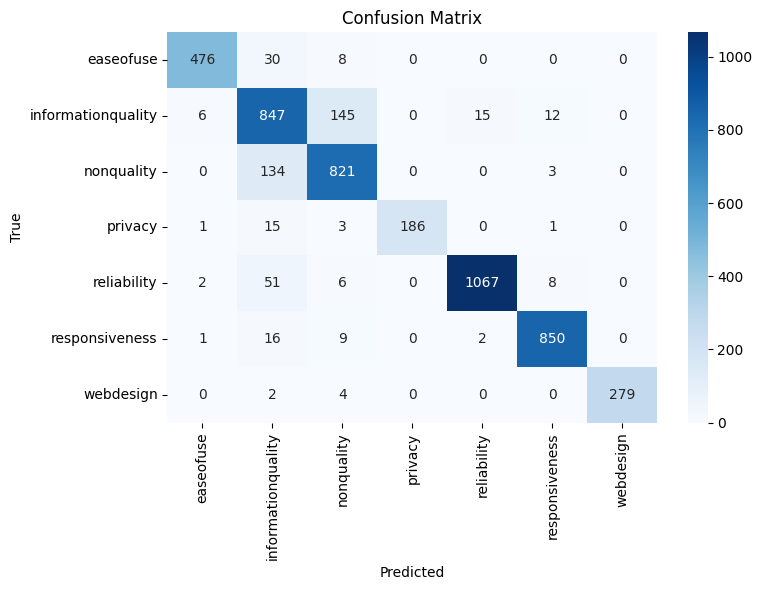

In [7]:
f1_scores = []
accuracies = []
precisions = []
recalls = []

# Tambahkan list untuk menyimpan semua y_test dan y_pred dari semua fold
all_y_true = []
all_y_pred = []

for i, (train_idx, test_idx) in enumerate(kf.split(X_tfidf, y), 1):
    X_train, X_test = X_tfidf[train_idx], X_tfidf[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train SVM
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    re = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n=== Fold {i} ===")
    print("Accuracy:", round(acc, 4))
    print("F1-score (macro):", round(f1, 4))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    accuracies.append(acc)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(re)

    # ⬇ Simpan hasil prediksi dari fold ini
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# 5. Confusion Matrix GLOBAL (dari semua fold)
cm_global = confusion_matrix(all_y_true, all_y_pred)

# Plot Confusion Matrix Global
plt.figure(figsize=(8, 6))
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [8]:
# 5. Summary of all folds
print("\n=== RATA-RATA FOLD ===")
for i in range(len(accuracies)):
    print(f"Fold {i+1} - "
        f"Acc: {round(accuracies[i], 4)}, "
        f"Precision: {round(precisions[i], 4)}, "
        f"Recall: {round(recalls[i], 4)}, "
        f"F1: {round(f1_scores[i], 4)}")

print("\n=== RATA-RATA MATRIX ===")
print("Average Accuracy   :", round(np.mean(accuracies), 4))
print("Average Precision  :", round(np.mean(precisions), 4))
print("Average Recall     :", round(np.mean(recalls), 4))
print("Average F1-score   :", round(np.mean(f1_scores), 4))


=== RATA-RATA FOLD ===
Fold 1 - Acc: 0.914, Precision: 0.9408, Recall: 0.9344, F1: 0.9368
Fold 2 - Acc: 0.894, Precision: 0.9239, Recall: 0.9026, F1: 0.912
Fold 3 - Acc: 0.914, Precision: 0.9375, Recall: 0.9294, F1: 0.9331
Fold 4 - Acc: 0.9, Precision: 0.9323, Recall: 0.9178, F1: 0.924
Fold 5 - Acc: 0.908, Precision: 0.9397, Recall: 0.9143, F1: 0.926
Fold 6 - Acc: 0.924, Precision: 0.9454, Recall: 0.9268, F1: 0.9344
Fold 7 - Acc: 0.892, Precision: 0.9223, Recall: 0.9012, F1: 0.9107
Fold 8 - Acc: 0.894, Precision: 0.9253, Recall: 0.9052, F1: 0.9142
Fold 9 - Acc: 0.914, Precision: 0.9385, Recall: 0.919, F1: 0.9277
Fold 10 - Acc: 0.898, Precision: 0.9272, Recall: 0.8988, F1: 0.9108

=== RATA-RATA MATRIX ===
Average Accuracy   : 0.9052
Average Precision  : 0.9333
Average Recall     : 0.915
Average F1-score   : 0.923


In [9]:
# 7. RATA-RATA PER LABEL (berdasarkan semua fold)
report = classification_report(all_y_true, all_y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_per_label = df_report.drop(["accuracy", "macro avg", "weighted avg"])

cm = confusion_matrix(all_y_true, all_y_pred)
label_counts = cm.sum(axis=1)  
correct_counts = np.diag(cm)   
accuracy_per_label = correct_counts / label_counts

df_per_label["accuracy"] = accuracy_per_label

print("\n=== RATA-RATA PER LABEL (Precision, Recall, F1-score, Accuracy) ===")
print(df_per_label[["precision", "recall", "f1-score", "accuracy"]])


=== RATA-RATA PER LABEL (Precision, Recall, F1-score, Accuracy) ===
                    precision    recall  f1-score  accuracy
easeofuse            0.979424  0.926070  0.952000  0.926070
informationquality   0.773516  0.826341  0.799057  0.826341
nonquality           0.824297  0.856994  0.840328  0.856994
privacy              1.000000  0.902913  0.948980  0.902913
reliability          0.984317  0.940917  0.962128  0.940917
responsiveness       0.972540  0.968109  0.970320  0.968109
webdesign            1.000000  0.978947  0.989362  0.978947
